#Import Libraries

In [ ]:
import torch
import gensim
import gensim.downloader as api
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import pandas as pd
from bs4 import BeautifulSoup
!pip install contractions
import contractions as ct
import re
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 31.8 MB/s eta 0:00:00


#Load Word2vec Model

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
wv = api.load('word2vec-google-news-300')

Mounted at /content/drive
[==================================================] 100.0% 1662.8/1662.8MB downloaded


#Define Functions

In [ ]:
def init_data(data_frame):
    data_frame.dropna(inplace=True)
    data_frame.drop_duplicates(inplace=True)
    data_frame['star_rating'] = data_frame['star_rating'].astype('int')
    return data_frame

In [ ]:
def data_cleaning(data_frame):
    for i in range(0, len(data_frame)):
        if data_frame['star_rating'][i] == 1 or data_frame['star_rating'][i] == 2:
            data_frame.loc[i, ['star_rating']] = 0
        elif data_frame['star_rating'][i] == 3:
            data_frame.loc[i, ['star_rating']] = 1
        elif data_frame['star_rating'][i] == 4 or data_frame['star_rating'][i] == 5:
            data_frame.loc[i, ['star_rating']] = 2

        review_text = data_frame['review_body'][i]
        # remove un-wanted html tags
        if BeautifulSoup(review_text, "html.parser").find():
            review_text = BeautifulSoup(review_text, "html.parser").get_text("　")
        # text extend contractions
        review_text = ct.fix(review_text)
        # remove non-alphabetical chars
        regex = re.compile('[^a-zA-Z]')
        review_text = regex.sub(' ', review_text)
        # convert to lower case
        review_text = review_text.lower().strip()
        review_text = " ".join(review_text.split())
        # end of data processing
        review_text = " ".join(review_text.split())
        # replace empty string with numpy's nan datatype
        if review_text != "":                  
            data_frame.loc[i, ['review_body']] = review_text
        else:
            data_frame.loc[i, ['review_body']] = np.nan
    return data_frame

In [ ]:
def data_prep(data):
    prepared_data = []
    for i in range (0,len(data)):
        words_list = data[i].split()
        vector_sum = np.zeros((300,))
        total_word = len(words_list)
        for word in words_list:
            if word in wv.vocab:
                vector_sum = vector_sum + wv[word]         
        prepared_data.append(vector_sum/total_word)
        
    return np.array(prepared_data)

In [ ]:
# Print the training result
def generate_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    print("Class 1 Precision: " + str(report[str(0)]['precision']) + ", Class 1 Recall: " + str(
        report[str(0)]['recall']) + ", Class 1 f1-score: " + str(report[str(0)]['f1-score']))
    print("Class 2 Precision: " + str(report[str(1)]['precision']) + ", Class 2 Recall: " + str(
        report[str(1)]['recall']) + ", Class 2 f1-score: " + str(report[str(1)]['f1-score']))
    print("Class 3 Precision: " + str(report[str(2)]['precision']) + ", Class 3 Recall: " + str(
        report[str(2)]['recall']) + ", Class 3 f1-score: " + str(report[str(2)]['f1-score']))
    print("Average Precision: " + str(report['macro avg']['precision']) + ", Averagage Recall: " + str(
        report['macro avg']['recall']) + ", Averagage f1-score: " + str(
        report['macro avg']['f1-score']))
    print("\n")

#Initialization

In [ ]:
RANDOM_SAMPLE_SIZE = 20000
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

#Prepare Balanced Dataset

In [ ]:
# reading data
df = pd.read_pickle("/content/drive/MyDrive/Dataset/data.pkl")
df = init_data(df).reset_index(drop=True)

# 3-classes dataset
class1_df = df[df['star_rating'] <= 2].sample(RANDOM_SAMPLE_SIZE)
class2_df = df[df['star_rating'] == 3].sample(RANDOM_SAMPLE_SIZE)
class3_df = df[df['star_rating'] >= 4].sample(RANDOM_SAMPLE_SIZE)

balanced_df = pd.concat([class1_df, class2_df, class3_df]).reset_index(drop=True)
#balanced_df['star_rating'] = balanced_df['star_rating'].astype('string')
cleaned_balanced_df = data_cleaning(balanced_df)
cleaned_balanced_df.dropna(inplace=True)

#Task 2a

In [ ]:
# 3 examples using word2vec-google-news-300
example_1 = wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))

ice + sport - walk ~= ('hockey', 0.5072677135467529)
gas + dangerous - stable ~= ('natural_gas', 0.4578143358230591)
cold + rain - sun ~= ('wet_weather', 0.5952470302581787)


#Task 2b

In [ ]:
sentences = cleaned_balanced_df["review_body"].tolist()
sentences_training = [index.split() for index in sentences ]
# Train Word2vec model with Amazon review data
my_word2vec = gensim.models.Word2Vec(sentences_training , size=300, window=13, min_count=9)


In [ ]:
# 3 examples using provided Amazon review
example_1 = my_word2vec.wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = my_word2vec.wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = my_word2vec.wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))


ice + sport - walk ~= ('apricot', 0.7340902090072632)
gas + dangerous - stable ~= ('purely', 0.5995689034461975)
cold + rain - sun ~= ('mat', 0.5979752540588379)


#Task 3

####Split dataset into Training and Testing Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_balanced_df['review_body'], cleaned_balanced_df['star_rating'], test_size=0.2)

#### Convert Datasets to Correct Format

In [ ]:
X_train_np = data_prep(X_train.to_numpy()) 
X_test_np = data_prep(X_test.to_numpy()) 
y_train_np = y_train.to_numpy()
y_test_np =  y_test.to_numpy()

#Cache

In [ ]:

with open('/content/drive/MyDrive/Dataset/X_train.npy', 'wb') as f:
    np.save(f, X_train_np)
with open('/content/drive/MyDrive/Dataset/X_test.npy', 'wb') as f1:
    np.save(f1, X_test_np)
with open('/content/drive/MyDrive/Dataset/y_train.npy', 'wb') as f2:
    np.save(f2, y_train_np)
with open('/content/drive/MyDrive/Dataset/y_test.npy', 'wb') as f3:
    np.save(f3, y_test_np)


#### Train Perceptron

In [ ]:
clf_perceptron = Perceptron()
clf_perceptron = clf_perceptron.fit(X_train_np, y_train_np)
y_pred_perceptron = clf_perceptron.predict(X_test_np)
generate_report(y_test_np, y_pred_perceptron)

Class 1 Precision: 0.4372982941447672, Class 1 Recall: 0.940272614622057, Class 1 f1-score: 0.5969632601683582
Class 2 Precision: 0.7133757961783439, Class 2 Recall: 0.08402100525131283, Class 2 f1-score: 0.15033557046979865
Class 3 Precision: 0.7748948106591865, Class 3 Recall: 0.5573770491803278, Class 3 f1-score: 0.6483790523690773
Average Precision: 0.6418563003274326, Averagage Recall: 0.5272235563512325, Averagage f1-score: 0.46522596100241137




####Train Linear SVC

In [ ]:
clf_linear_svc = LinearSVC()
clf_linear_svc = clf_linear_svc.fit(X_train_np, y_train_np)
y_pred_linear_svc = clf_linear_svc.predict(X_test_np)
generate_report(y_test_np, y_pred_linear_svc)

Class 1 Precision: 0.6594464500601684, Class 1 Recall: 0.6790582403965304, Class 1 f1-score: 0.6691086691086691
Class 2 Precision: 0.5976980728051392, Class 2 Recall: 0.5583895973993498, Class 2 f1-score: 0.5773755656108597
Class 3 Precision: 0.7266309639727361, Class 3 Recall: 0.7528373266078184, Class 3 f1-score: 0.7395020438498698
Average Precision: 0.6612584956126812, Averagage Recall: 0.6634283881345663, Averagage f1-score: 0.6619954261897996




#Task 4a

##Read Cache

In [73]:
from google.colab import drive
import numpy as np
drive.mount("/content/drive", force_remount=True)

with open('/content/drive/MyDrive/Dataset/X_train.npy', 'rb') as f:
    X_train_np_c = np.load(f,allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/y_train.npy', 'rb') as f:
    y_train_np_c = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/X_test.npy', 'rb') as f:
    X_test_np_c = np.load(f)
with open('/content/drive/MyDrive/Dataset/y_test.npy', 'rb') as f:
    y_test_np_c = np.load(f, allow_pickle=True)  


Mounted at /content/drive


ValueError: ignored

####Define functions

In [669]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import transforms,datasets
import matplotlib.pyplot as plt

def test_acc(model, dataloader):
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            outputs = model(data)
            # Calculate the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    accuracy = 100 * correct / total      
    print('Test accuracy: {:.16f}%'.format(accuracy))

def plot_loss(train_loss, test_loss, val_loss):
    epochs = len(train_loss)
    x = range(epochs)

    plt.plot(x, train_loss, label='Training Loss')
    plt.plot(x, test_loss, label='Testing Loss')
    plt.plot(x, val_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


####Setup Dataloader

In [670]:
BATCH_SIZE = 256

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

X_train_tensor = torch.Tensor(X_train_np_c)
X_test_tensor  = torch.Tensor(X_test_np_c)
y_train_tensor = torch.Tensor(y_train_np_c)
y_test_tensor = torch.Tensor(y_test_np_c)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

train_dataset, validation_dataset = random_split(train_dataset,[0.9,0.1])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True) 

Using cuda device


####MLP constructor

In [671]:
class MLP(nn.Module):
    
  def __init__(self):
    super().__init__()
    hidden_1 = 100
    hidden_2 = 10
    dropout_p = 0.5

    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(300, hidden_1),
      nn.BatchNorm1d(hidden_1),
      nn.ReLU(),
      nn.Dropout(p=dropout_p),
      nn.Linear(hidden_1, hidden_2),
      nn.BatchNorm1d(hidden_2),
      nn.ReLU(),
      nn.Dropout(p=dropout_p),
      nn.Linear(hidden_2, 3),
    )

  def forward(self, x):
    return self.layers(x)

####Train MLP and output result

Early stopping


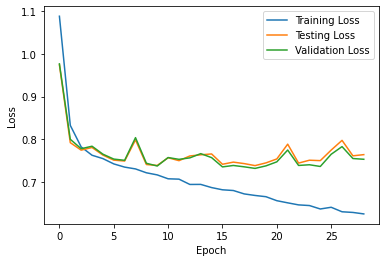

Test accuracy: 67.3972831069255705%


In [676]:
mlp = MLP()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(mlp.parameters(),weight_decay=0.001)

best_loss = float('inf')
patience = 10
counter = 0
train_list = []
valid_list = []
test_list = []

# Training loop
for epoch in range(0,100): 
        
    train_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
      inputs, targets = data
      
      optimizer.zero_grad()
      outputs = mlp(inputs)
      targets = targets.type(torch.LongTensor)
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    
    # record train loss
    train_list.append(train_loss / len(train_dataloader))
 
    # record validation loss
    valid_loss = 0.0
    mlp.eval()  
    for i, data in enumerate(validation_dataloader, 0):
        inputs, targets = data
        outputs = mlp(inputs)
        targets = targets.type(torch.LongTensor)
        loss = loss_function(outputs, targets)
        valid_loss += loss.item()
    valid_list.append(valid_loss / len(validation_dataloader))
   
    # record test loss
    mlp.eval()  
    testing_loss = 0.0
    with torch.no_grad():
        for data, target in test_dataloader:
            output = mlp(data)
            target = target.type(torch.LongTensor)
            loss = loss_function(output, target)
            testing_loss += loss.item() * data.size(0)
            
    testing_loss /= len(test_dataloader.dataset)
    test_list.append(testing_loss)
    
    # early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        counter = 0
        torch.save(mlp.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# Use the best model obtained from the early stopping process
mlp.load_state_dict(torch.load('best_model.pt'))
plot_loss(train_list, test_list, valid_list)    
test_acc(mlp,test_dataloader)
